In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch#텐서 등의 다양한 수학 함수가 포함된 라이브러리
import torch.nn as nn #신경망 구축을 위한 데이터 구조나 레이어 등의 라이브러리
from torch.autograd import Variable #자동 미분 기능을 제공하는 라이브러리
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms#데이터 전처리를 위한 라이브러리
from torch.utils.data import Dataset,DataLoader#데이터 조작 등 유틸리티 기능 제공

In [2]:
device = torch.device("cuda:0")
print(torch.cuda.is_available())

True


In [3]:
train_dataset=torchvision.datasets.FashionMNIST("./",download=True,transform=transforms.Compose([transforms.ToTensor()]))
#저공간에다 패션 데이터셋 을 다운 받겠다는 의미 또한 다운받은 이미지 데이터를 텐서로 변환
#파라미터
#첮번쨰 경로는 데이터를 내려받을 위치
#download-트루로 변경ㅎ라면 첫번째 파라미터 위치에 해당 데이터셋이 있는지 확인후 내려받음
#transform:이미지를 텐서로 변환

100%|██████████| 26421880/26421880 [00:08<00:00, 3055911.44it/s]


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 101752.45it/s]


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1393320.29it/s]


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw



In [4]:
print(len(train_dataset))

60000


In [5]:
test_dataset=torchvision.datasets.FashionMNIST("./",train=False,download=True,transform=transforms.Compose([transforms.ToTensor()]))

In [6]:
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


패션 데이터를 데이터 로더에 전달

In [7]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=100)
#이 메소드를 사용하여 원하는 크기의 배치 단위로 데이터를 불러오거나 순서가
#무작위로 섞이도록 할 수 있다.
#파라미터: train_dataset-데이터를 불러올 데이텃셋 지정,batch_size-얼마 만큼 묶어서 데이터를 불러올지 정함
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=100)

In [8]:
print(len(train_loader))

600


분류에 사용될 클래스 정의

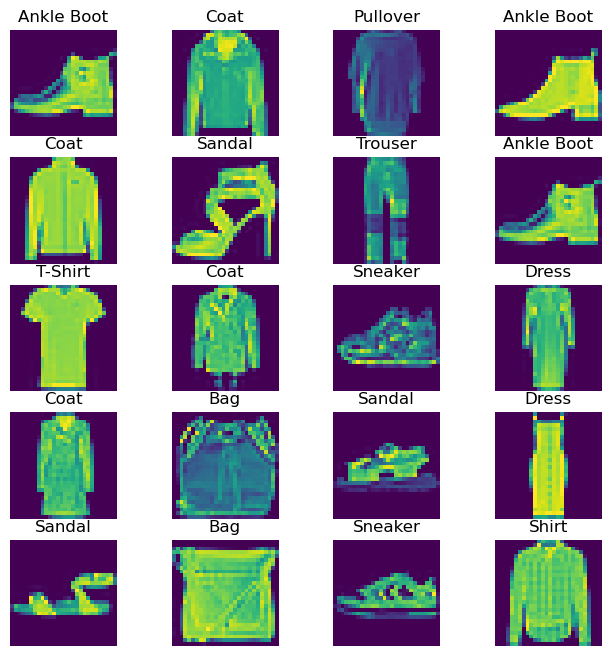

In [9]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img,)
plt.show()
#랜덤으로 이미지 출력

심층 신경망 모델 생성

In [9]:
class FashionDNN(nn.Module): #클래스 형태의 모델은 항상 nn.Module를 상속받는다.
    def __init__(self): #__init__()은 객체가 갖는 속성 값을 초기화 하는 역할을 하며 객테가 생성될때 자동으로 호출된다.
        super(FashionDNN,self).__init__()#이코드는 FashionDNN이라는 부모 클래스를 상속 받겠다는 의미로 이해하면된다.
        self.fc1=nn.Sequential(
            nn.Linear(in_features=784,out_features=256),
            nn.ReLU())
        self.drop=nn.Dropout(0.25)#25%의 비율로 텐서의 값이 0이되고 0이 되지 않는 값들은 기존 값에(1/1-0.25)만큼 곱해져 커짐
        self.fc2=nn.Sequential(
            nn.Linear(in_features=256,out_features=128),
            nn.ReLU())
        self.fc3=nn.Linear(in_features=128,out_features=10)
    def forward(self,input_data):#모델이 학습 데이터를 입력받아 순전파 학습을 진행시키는 함수이다.
        out= input_data.view(-1,784)#데이터를 길게 늘림
        out=self.fc1(out)#활성화 함수를 지정함
        out=self.drop(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return(out)
    
    #활성화 함수는 두가지 방법으로 지정히 가능하다 F.relu():forward()함수에서 정의
    #                                          nn.relu():__init__()함수에서 정의

심층 신경망에 필요한 파라미터 정의

In [10]:
learning_rate=0.001
model=FashionDNN()
model.to(device)
criterion=nn.CrossEntropyLoss()#손실 함수 정의
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
#옵티마이저를 위한 경사하강법의로 아담지정, 학습률 지정
print(model)

FashionDNN(
  (fc1): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
  )
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)#GPU로 데이터 처리함 why? 모델이 GPU로 처리되어서
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        #자동미분(역전파를 위해, 근데 굳이 안해도 된다.)
        outputs = model(train)
        #순전파
        loss = criterion(outputs, labels)
        #손실함수에다 정답하고 예측값을 보냄
        optimizer.zero_grad()
        #가중치 초기화
        loss.backward()
        #역전파
        optimizer.step()
        #파라미터 업데이트
        count += 1
        #얼마나 반복했는지 세기 위헤
        if not (count % 50):#50번째 반복마다 실행    
            total = 0
            correct = 0        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)            
                test = Variable(images.view(100, 1, 28, 28))            
                outputs = model(test)            
                predictions = torch.max(outputs, 1)[1].to(device)
                #제일 확률이 높은 놈을 예측으로(분류 문제여서)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5826607942581177, Accuracy: 83.44999694824219%
Iteration: 1000, Loss: 0.4535296559333801, Accuracy: 84.61000061035156%
Iteration: 1500, Loss: 0.3684860169887543, Accuracy: 84.1500015258789%
Iteration: 2000, Loss: 0.4103727340698242, Accuracy: 85.56999969482422%
Iteration: 2500, Loss: 0.25931504368782043, Accuracy: 86.54000091552734%
Iteration: 3000, Loss: 0.3020419478416443, Accuracy: 86.5%


 합성곱 네트쿼크 생성

In [12]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN,self).__init__()#uper()로 기반 클래스(부모 클래스)를 초기화해줌으로써, 기반 클래스의 속성을 subclass가 받아오도록 한다. (초기화를 하지 않으면, 부모 클래스의 속성을 사용할 수 없음)
        self.layer1=nn.Sequential(#일종의 컨테이터 역할로 신경망을 가독성이 좋은 형태로 표현한다.
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
            #합성곱 층이다. 파라미터는 입력 채널의 수( RGB라면 3), 출력 커널수, 커널 사이지, 패딩이다.
            nn.BatchNorm2d(32),
            #각 배치별로 데이터가 다양한 형태를 가지더라도 평균과 분산을 이용하여
            #정규화한다. 즉 분포를 가우시안 형태로 만들어 평균은 0 표준편차는 1로 데이터 분포가 조정된다.
            #참고로 안의 숫자는 데이터 채널의 개수이다.
            nn.ReLU(),
            #활성화 함수
            nn.MaxPool2d(kernel_size=2,stride=2)
            #이미지를 축소시키는 용도로 사용한다. 참고로 최대 풀링이다.
        )
        self.layer2=nn.Sequential(

            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3),#합성곱
            nn.BatchNorm2d(64),#정규화
            nn.ReLU(),#활성화 함수
            nn.MaxPool2d(2)#풀링
        )
        #합성곱 계층에서 출력을 크기를 구하는 공식은 다음과 같다.
        #(입력데이터의 크기-커널크기+2*패딩크기)/(스트라이드)+1
        #만약에 n,m의 이미지라면 각각의 공식에 대입하면된다.
        #최대 풀링 계층에서 출력크기를 구하는 공식은 다음과 같다.
        #출력 크기=입력 필터의 크기/커널크기
        #레이어 1의 합성곱 출력크기=(28-3+2)/1+1=28
        #레이어 1의 최대풀링 출력크기=14
        #레이어 2의 합성곱 출력크기=(14-3)/1+1=12
        #레이어 2의 최대풀링 출력크기=12/2=6
        self.fc1=nn.Linear(in_features=64*6*6,out_features=600)
        self.drop=nn.Dropout2d(0.25)
        self.fc2=nn.Linear(in_features=600,out_features=120)
        self.fc3=nn.Linear(in_features=120,out_features=10)
    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=out.view(out.size(0),-1)
        out=self.fc1(out)
        out=self.drop(out)
        out=self.fc2(out)
        out=self.fc3(out)
        return out



합성곱 네트워크를 위한 파라미터 정의

In [13]:
learning_rate=0.0001
model=FashionCNN()
model.to(device)#모델을 gpu에서 처리
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [14]:
num_epochs=5
count=0
loss_list=[]
iteration_list=[]
accuracy_list=[]
predictions_list=[]
labels_list=[]
for epoch in range(num_epochs):
    for images,labels in train_loader:
        images,labels= images.to(device),labels.to(device)
        train=Variable(images.view(100,1,28,28))
        labels=Variable(labels)
        outputs=model(train)
        loss=criterion(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1
        if (count%50==0):
            total=0
            correct=0
            for images,labels in test_loader:
                images,labels=images.to(device),labels.to(device)
                test=Variable(images.view(100,1,28,28))
                outputs=model(test)
                predictions=torch.max(outputs.data,1)[1].to(device)
                predictions_list.append(predictions)
                correct+=(predictions==labels).sum()
                total+=len(labels)
            accuracy=correct/total*100
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if(count%500==0):
            print("iteration:%d, Loss:%f, Accuracy:%f"%(count,loss.data,accuracy))

c:\Users\user\anaconda3\Lib\site-packages\torch\nn\functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


iteration:500, Loss:0.487280, Accuracy:87.329994
iteration:1000, Loss:0.314182, Accuracy:88.949997
iteration:1500, Loss:0.269122, Accuracy:88.540001
iteration:2000, Loss:0.219305, Accuracy:89.690002
iteration:2500, Loss:0.198764, Accuracy:90.160004
iteration:3000, Loss:0.189632, Accuracy:89.440002
